In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../..')
from database.connection import get_db_manager
from viz.scatter import create_diamond_scatter

In [2]:
BACKGROUND_COLOR = '#313332'
FONT_FAMILY = 'DejaVu Sans'

node_cmap = mcolors.LinearSegmentedColormap.from_list("", [
    'deepskyblue', 'cyan', 'lawngreen', 'yellow', 
    'gold', 'lightpink', 'tomato'
])

os.makedirs('figures', exist_ok=True)

In [3]:
db = get_db_manager()

query = """
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.season = '2425'
ORDER BY p.league, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extracted: {df_raw.shape[0]} records")

2025-09-21 10:34:11,978 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-09-21 10:34:12,573 - database.connection - INFO - Database connection successful


Extracted: 2772 records


In [4]:
# Filtrar por minutos mínimos PRIMERO (como en mika.ipynb)
df_filtered = df_raw[
    df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= 800
].copy()

print(f"Filtro 800+ min: {df_filtered.shape[0]} jugadores")

# Funciones de extracción (como en mika.ipynb)
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

Filtro 800+ min: 1627 jugadores
FBref: 185 métricas | Understat: 10 métricas


In [5]:
# Métricas a excluir de per90 (como en mika.ipynb)
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

# Calcular percentiles (como en mika.ipynb)
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Per90: 154 + 7
Métricas totales: 356
Percentiles totales: 356


In [6]:
# DataFrame final consolidado (como en mika.ipynb)
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados (como en mika.ipynb)
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

# Usar df_final como df principal
df = df_final.copy()
print(f"DataFrame final: {df.shape[0]} jugadores con 800+ minutos")

# PRINT DE TODAS LAS COLUMNAS DISPONIBLES
print("\n" + "="*80)
print("TODAS LAS COLUMNAS DISPONIBLES EN EL DATAFRAME")
print("="*80)

# Separar por tipo de columna
base_columns = [col for col in df.columns if col in base_cols]
fbref_metrics = [col for col in df.columns if col in fbref_nums.columns]
understat_metrics = [col for col in df.columns if col in understat_nums.columns]
per90_metrics = [col for col in df.columns if col.endswith('_per90')]
percentile_metrics = [col for col in df.columns if col.endswith('_pct')]

print(f"\n1. COLUMNAS BASE ({len(base_columns)}):")
for i, col in enumerate(base_columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n2. MÉTRICAS FBREF ({len(fbref_metrics)}):")
for i, col in enumerate(sorted(fbref_metrics), 1):
    print(f"   {i:3d}. {col}")

print(f"\n3. MÉTRICAS UNDERSTAT ({len(understat_metrics)}):")
for i, col in enumerate(sorted(understat_metrics), 1):
    print(f"   {i:2d}. {col}")

print(f"\n4. MÉTRICAS PER90 ({len(per90_metrics)}):")
for i, col in enumerate(sorted(per90_metrics), 1):
    print(f"   {i:3d}. {col}")

print(f"\n5. PERCENTILES ({len(percentile_metrics)}):")
print("   (Mostrando primeros 20 para evitar spam)")
for i, col in enumerate(sorted(percentile_metrics)[:20], 1):
    print(f"   {i:2d}. {col}")
if len(percentile_metrics) > 20:
    print(f"   ... y {len(percentile_metrics) - 20} más")

print(f"\nRESUMEN TOTAL:")
print(f"- Base: {len(base_columns)}")
print(f"- FBref: {len(fbref_metrics)}")
print(f"- Understat: {len(understat_metrics)}")
print(f"- Per90: {len(per90_metrics)}")
print(f"- Percentiles: {len(percentile_metrics)}")
print(f"- TOTAL: {df.shape[1]} columnas")

# Crear DataFrames separados para delanteros y porteros
print("\n" + "="*80)
print("CREANDO DATAFRAMES SEPARADOS")
print("="*80)

# DataFrame para delanteros (FW)
df_fw = df[df['position'].str.contains('FW', na=False)].copy()
df_fw = df_fw.dropna(subset=['expected_goals', 'goals'])
print(f"\nDelanteros (FW): {df_fw.shape[0]} jugadores disponibles")
print(f"Columnas en df_fw: {df_fw.shape[1]}")

# DataFrame para porteros (GK) 
df_gk = df[df['position'].str.contains('GK', na=False)].copy()
df_gk = df_gk.dropna(subset=['Save%', 'PSxG+/-'])
print(f"Porteros (GK): {df_gk.shape[0]} jugadores disponibles")
print(f"Columnas en df_gk: {df_gk.shape[1]}")

DataFrame final: 1627 filas, 718 columnas
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales
DataFrame final: 1627 jugadores con 800+ minutos

TODAS LAS COLUMNAS DISPONIBLES EN EL DATAFRAME

1. COLUMNAS BASE (6):
    1. unique_player_id
    2. player_name
    3. team
    4. league
    5. season
    6. position

2. MÉTRICAS FBREF (184):
     1. /90
     2. 2CrdY
     3. A-xAG
     4. Aerial Duels_Lost
     5. Aerial Duels_Won
     6. Aerial Duels_Won%
     7. Blocks_Blocks
     8. Blocks_Pass
     9. Blocks_Sh
    10. CS
    11. CS%
    12. Carries_1/3
    13. Carries_CPA
    14. Carries_Carries
    15. Carries_Dis
    16. Carries_Mis
    17. Carries_PrgC
    18. Carries_PrgDist
    19. Carries_TotDist
    20. Challenges_Att
    21. Challenges_Lost
    22. Challenges_Tkl
    23. Challenges_Tkl%
    24. Corner Kicks_In
    25. Corner Kicks_Out
    26. Corner Kicks_Str
    27. Crosses_Opp
    28. Crosses_Stp
    29. 

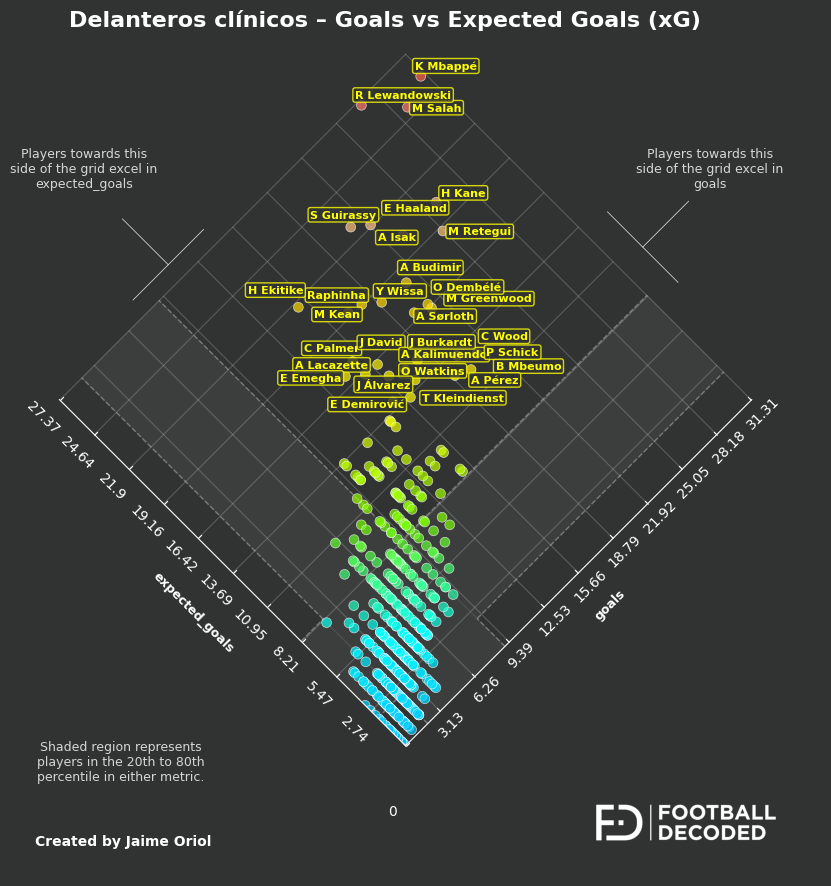

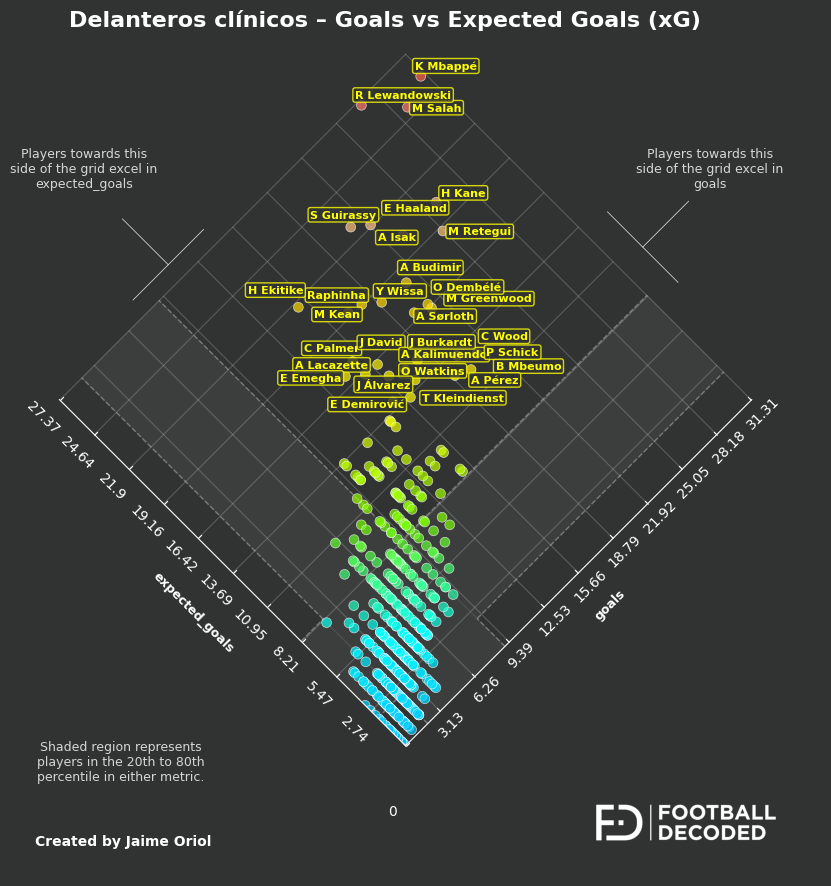

In [7]:
# Diamond scatter plot para delanteros: Goals vs Expected Goals
create_diamond_scatter(
    df_fw,
    x_metric='expected_goals',
    y_metric='goals', 
    title='Delanteros clínicos – Goals vs Expected Goals (xG)',
    save_filename='delanteros_goals_vs_xg_diamond.png'
)

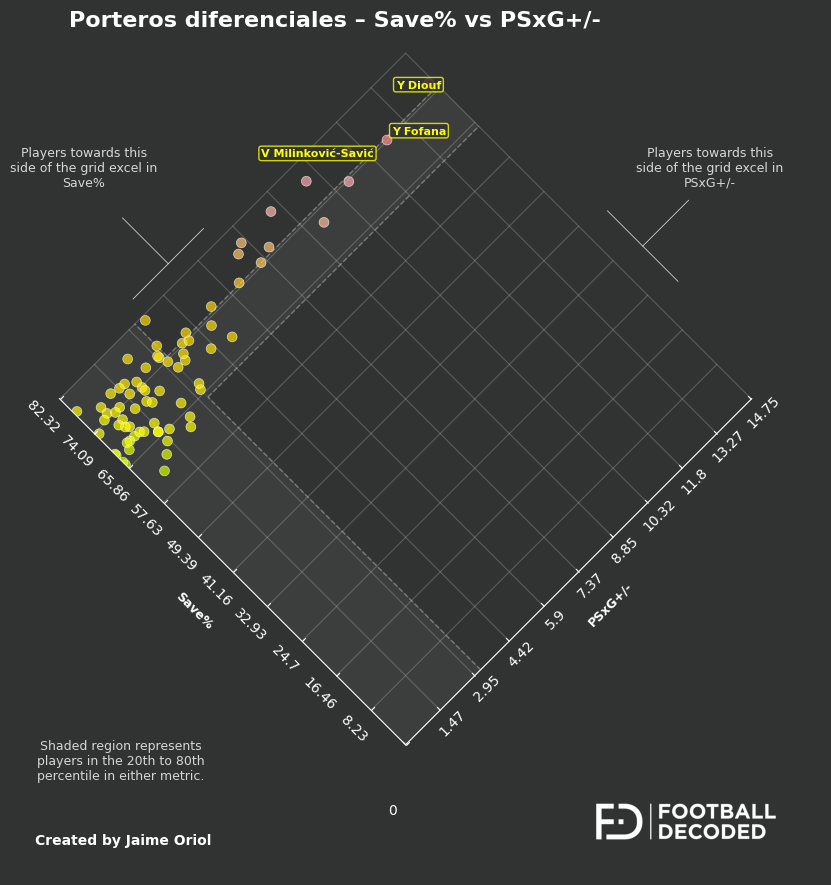

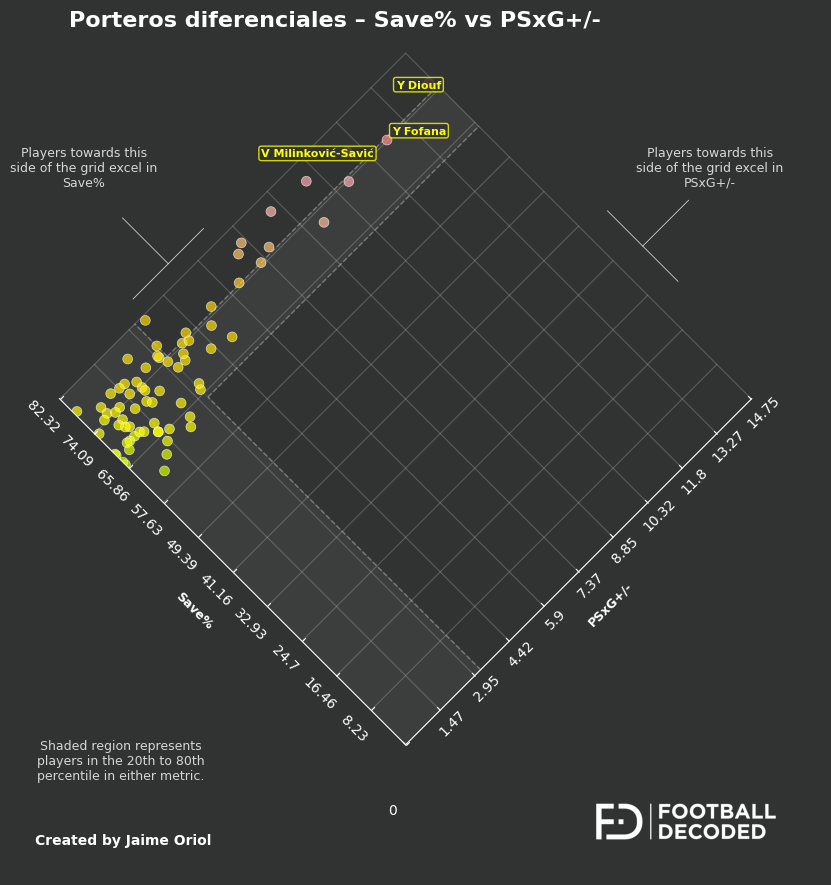

In [8]:
# Diamond scatter plot para porteros: Save% vs PSxG+/-
create_diamond_scatter(
    df_gk,
    x_metric='Save%',
    y_metric='PSxG+/-',
    title='Porteros diferenciales – Save% vs PSxG+/-',
    save_filename='porteros_save_vs_psxg_diamond.png'
)